# Fractional Ignorance (FI) and its Skill Score (FISS)
## John R. Lawson, 2019
### CIMMS/NSSL, Norman, OK, USA.

We start with the canonical Shannon (1948, Bell Labs) equation for information theory:

H = 

The measure of information that is provided by the observation of event k is:

\begin{align}
IGN = - log_2 Pr(k)
\end{align}

where Pr(k) is the probability of the event k occurring. This can also be considered the optimal data compression scheme to represent event k. For instance:

In [69]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [70]:
%pdb off
%matplotlib inline
import matplotlib as M
import matplotlib.pyplot as plt
import numpy as N
N.set_printoptions(precision=2)



def compute_ign(pr_k):
    return -N.log2(pr_k)

# The probability of a coin landing on heads
pr_k = 0.5
# This yields ignorance of 1 bit:
print(compute_ign(pr_k))

Automatic pdb calling has been turned OFF
1.0


To test this in a meteorological context, let's generate some synthetic data. In the following, `fcst_cube` is a 3x3x3 cube, representing three ensemble members and their prognosis of 2-m temperature (in Celsius) after one hour. The variable `obs_cube` shows the observed 2-m temperature, assuming zero observational error. Then, we compute ignorance of temperatures exceeding 10 C before the observations are received:

Probabilities:
 [[0.67 0.33 0.67]
 [0.   0.33 0.67]
 [0.33 0.33 0.33]]


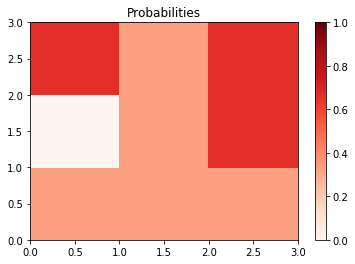

In [71]:
def compute_ign_bounded(pr_k,pr_min=0.02,pr_max=0.98):
    pr_k = N.array(pr_k)
    pr_k[pr_k < pr_min] = pr_min
    pr_k[pr_k > pr_max] = pr_max
    return compute_ign(pr_k)

def prob_of_exceedence(arr4D,thresh):
    # A 4D array is converted to a 2D probability array
    exceed = arr4D > thresh
    nt, nens, nlat, nlon = arr4D.shape
    probs = N.sum(exceed,axis=1)/nens
    return probs[0,:,:]

# The dimensions are [ensemble, latitude, longitude]
fcst_cube = N.random.uniform(low=5.0,high=15.0,size=(1,3,3,3))
obs_cube = N.random.uniform(low=8.0,high=12.0,size=(1,1,3,3))

# Existing ignorance, spatially:
fcst_prob = prob_of_exceedence(fcst_cube,10.0)
print("Probabilities:\n",fcst_prob)

fig,ax = plt.subplots(1)
pf = ax.pcolormesh(N.flipud(fcst_prob),vmin=0,vmax=1,cmap=M.cm.Reds)
plt.colorbar(pf)
ax.set_title("Probabilities")
display(pf)




Ignorance: [[0.58 1.58 0.58]
 [5.64 1.58 0.58]
 [1.58 1.58 1.58]]


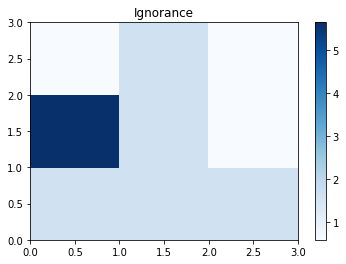

In [72]:
ignorance_square = compute_ign_bounded(fcst_prob)

# Plot 3x3 raw and thresholded?
print("Ignorance:",ignorance_square)

fig,ax = plt.subplots(1)
pf = ax.pcolormesh(N.flipud(ignorance_square),cmap=M.cm.Blues)
plt.colorbar(pf)
ax.set_title("Ignorance")
display(pf)

This is the climatological ignorance in the event a perfect model is being used (e.g., it can be ran over a frozen dataset).

But what is the ignorance before the forecast is received? This is analogous to the problem of determining a climatology for heterogeneous fields (such as radar reflectivity at the thunderstorm scale). In the event of zero prior information (even memory) available to the forecaster, we can define this as naive ignorance (NIGN). However, the more realistic ignorance before a forecast is issued is the typical ignorance (TIGN). This is typically persistence or climatology in traditional, synoptic-scale studies. However, this makes little sense in the thunderstorm context. 

For this section, we now consider a 10x10x10 cube. Instead of evaluating at a specific point in time and space, let us define a temporal and spatial tolerance, which mimicks the filtering performed by a forecaster when they typically consider a nowcast (this is related to the assumption of optimal encoding of information). Here, we set $\pm$5 minutes and a 3x3 window.

To introduce tolerance, we:
1. Create a 4D hypercube window across time, ensemble member, latitude, and longitude,
2. Start at the top-left corner
3. Compute the fraction of voxels within the window that exceed a given threshold
4. Assign this value to the central voxel
5. Continue until every permutation is complete (no computation is performed if the hypercube extends over the dataset hypercube boundaries)

Let us recompute ignorance with this tolerance applied. For sanity, we expect the resulting ignorance to fall, given the lower amount of information required to pin down exact locations of exceedence:

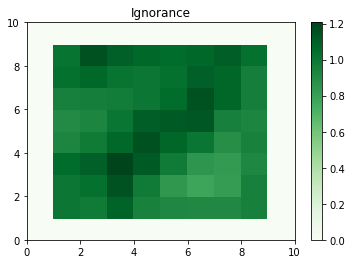

In [73]:
import itertools

fcst_cube = N.random.uniform(low=5.0,high=15.0,size=(3,10,10,10))
obs_cube = N.random.uniform(low=8.0,high=12.0,size=(3,1,10,10))

#fcst_prob = prob_of_exceedence(fcst_cube,10.0)

ign = N.zeros([1,1,10,10])
# For each window, count number of voxels in 4D window
# This maintains the ensemble pdf
# divided by number of voxels, giving fraction
for i,j in itertools.product(N.arange(1,9),N.arange(1,9)):
    window_i = slice(i-1,i+2)
    window_j = slice(j-1,j+2)
    # Grab the window subset
    window = fcst_cube[:,:,window_i,window_j]
    fraction = N.sum(window > 10.0)/window.size
    # fraction is % of voxels over threshold
    
    # ign is the ignorance of the forecast
    ign[0,0,i,j] = compute_ign_bounded(fraction)

fig,ax = plt.subplots(1)
pf = ax.pcolormesh(N.flipud(ign[0,0,:,:]),cmap=M.cm.Greens)
plt.colorbar(pf)
ax.set_title("Ignorance")
display(pf)

For a given pixel above, if the observation exceeds the threshold, then the information provided by the forecast is given above. Otherwise, zero information is gained for that pixel.



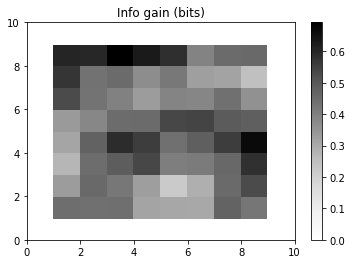

In [74]:
observed = N.zeros([1,1,10,10])

for i,j in itertools.product(N.arange(1,9),N.arange(1,9)):
    window_i = slice(i-1,i+2)
    window_j = slice(j-1,j+2)
    # Grab the window subset
    window = obs_cube[:,:,window_i,window_j]
    fraction = N.sum(window > 10.0)/window.size
    observed[0,0,i,j] = fraction
    
# Find where observed and forecast fraction is equal
# This indicates information communicated
# Near values get "pity points" as it is (non?) local
info_gain = observed * ign

fig,ax = plt.subplots(1)
pf = ax.pcolormesh(N.flipud(info_gain[0,0,:,:]),cmap=M.cm.Greys)
plt.colorbar(pf)
ax.set_title("Info gain (bits)")
display(pf)